In [1]:
import numpy as np

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Compressed Linformer Block (No Attention)
# ---------------------------
class CompressedLinformerBlockNoAttention(layers.Layer):
    """
    This block mimics a Linformer with compression=1.
    Since the attention matrix becomes trivial (a column of ones),
    we remove the query/key computations and only process the value tensor.
    The value tensor is split into heads, and for each head a learned projection F 
    compresses the sequence dimension down to 1. The results are then concatenated 
    and passed through a final dense layer.
    
    For an input of shape (batch, seq_len, d_model) with d_model divisible by num_heads:
      - Compute V = W_v * x.
      - Split V into (batch, num_heads, seq_len, depth).
      - For each head, apply the learned projection F (shape: (num_heads, seq_len, 1))
        via an Einstein summation to compress seq_len to 1.
      - Squeeze and concatenate to get (batch, d_model).
      - Apply a final Dense layer.
    """
    def __init__(self, d_model, num_heads, **kwargs):
        super(CompressedLinformerBlockNoAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        
        # This dense layer computes the value tensor V.
        self.wv = layers.Dense(d_model, name="wv")
        # Final dense layer after concatenation.
        self.dense = layers.Dense(d_model, name="dense_out")
    
    def build(self, input_shape):
        # input_shape: (batch, seq_len, d_model)
        self.seq_len = input_shape[1]
        # Learned projection F for each head: shape (num_heads, seq_len, 1)
        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, 1),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(CompressedLinformerBlockNoAttention, self).build(input_shape)
    
    def split_heads(self, x, batch_size):
        # Reshape x from (batch, seq_len, d_model) to (batch, seq_len, num_heads, depth)
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
        # Transpose to (batch, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Compute the value tensor V.
        v = self.wv(x)  # (batch, seq_len, d_model)
        # Split V into multiple heads.
        v = self.split_heads(v, batch_size)  # (batch, num_heads, seq_len, depth)
        # For each head, apply the learned projection F to compress the sequence dimension:
        #   v_proj[b, h] = sum_{n} v[b, h, n, :] * F[h, n, 1]
        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)  # (batch, num_heads, 1, depth)
        # Remove the singleton sequence dimension.
        v_proj = tf.squeeze(v_proj, axis=2)  # (batch, num_heads, depth)
        # Concatenate heads back into one vector.
        concat = tf.reshape(v_proj, (batch_size, self.d_model))  # (batch, d_model)
        # Final dense layer.
        output = self.dense(concat)
        return output

# ---------------------------
# Compressed Linformer Classifier Model (No Attention)
# ---------------------------
def build_compressed_linformer_no_attention_classifier(num_particles, feature_dim,
                                                       d_model=16, num_heads=8, output_dim=5):
    """
    Builds a classifier model that uses the CompressedLinformerBlockNoAttention.
    
    Architecture:
      - Input: (num_particles, feature_dim)
      - Embedding: A Dense layer to project inputs to d_model.
      - CompressedLinformerBlockNoAttention: Compresses the sequence dimension via the value branch.
      - Post-processing: Additional Dense layer.
      - Output: Final Dense layer with softmax activation.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    # Initial embedding layer.
    x = layers.Dense(d_model, activation='relu', name="embedding_dense")(inputs)
    # Compressed Linformer block without attention.
    x = CompressedLinformerBlockNoAttention(d_model, num_heads)(x)
    # Optional additional processing.
    x = layers.Dense(d_model, activation='relu', name="post_dense")(x)
    outputs = layers.Dense(output_dim, activation='softmax', name="output_dense")(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Load Model Weights and Example Usage
# ---------------------------
if __name__ == '__main__':
    import numpy as np
    from sklearn.model_selection import train_test_split

    # Load your data.
    x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
    y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

    # 80/20 train/validation split.
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42, shuffle=True
    )

    # Determine input dimensions.
    num_particles = x_train.shape[1]
    feature_dim = x_train.shape[-1]

    # Build the model.
    model = build_compressed_linformer_no_attention_classifier(num_particles, feature_dim,
                                                               d_model=16, num_heads=8, output_dim=5)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Load the pre-saved weights (these should correspond to a model with compress=1).
    weights_path = "/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/1layerLinformerCompress1.weights.h5"
    model.load_weights(weights_path, skip_mismatch=True)
    
    # Print the model summary.
    model.summary()
    
    # Optionally, train or evaluate the model.
    # history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy'

In [47]:
# Train the model.
history = model.fit(x_train, y_train,
                    epochs=1000,         # adjust number of epochs as needed
                    batch_size=1024,
                    validation_data=(x_val, y_val))

Epoch 1/1000


2025-03-26 23:19:47.536084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.3663 - loss: 1.4268 - val_accuracy: 0.5830 - val_loss: 1.0737
Epoch 2/1000
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.5871 - loss: 1.0635 - val_accuracy: 0.5992 - val_loss: 1.0343
Epoch 3/1000
485/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.6032 - loss: 1.0227 - val_accuracy: 0.6133 - val_loss: 1.0027
Epoch 4/1000
485/485 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.6152 - loss: 0.9967 - val_accuracy: 0.6175 - val_loss: 0.9915
Epoch 5/1000
485/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.6188 - loss: 0.9891 - val_accuracy: 0.6215 - val_loss: 0.9841
Epoch 6/1000
485/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.6242 - loss: 0.9782 - val_accuracy: 0.6239 - val_loss: 0.9776
Epoch 7/1000
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.6248 - loss: 0.9736 - val_accuracy: 0.6255 - val_loss: 0.9750
Epoch 8/1000
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.6282 - loss: 0.9692

KeyboardInterrupt: 

In [43]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    # Create a concrete function from the Keras model.
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    # Convert the model to a frozen graph.
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Import the graph_def into a new graph.
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Assuming x_val is already loaded and has shape (num_samples, features, ...)
# For a single event, we use a batch size of 1.
input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
# Warm-up: Run one inference to load any lazy initializations.
import numpy as np
import time

# Warm-up (optional but recommended)
_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

# Compute average inference time per event in seconds, then convert to nanoseconds
avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2025-03-26 21:38:47.883273: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-03-26 21:38:47.883438: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-03-26 21:38:47.883703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-26 21:38:47.883715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference: 3566

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. No

In [37]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_16const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_16const_ptetaphi.npy")

In [38]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

In [39]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

0.6852

In [41]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

1/FPR at TPR=80% for each class:
g: 1/FPR = 4.607919737192578
q: 1/FPR = 5.5326362484157166
W: 1/FPR = 8.735127180996427
Z: 1/FPR = 6.905445840813885
t: 1/FPR = 13.865824308062574
Average 1/FPR across classes: 7.929390663096237

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.7864
q: accuracy = 0.8155
W: accuracy = 0.8683
Z: accuracy = 0.8441
t: accuracy = 0.9020
Average accuracy across classes: 0.8433


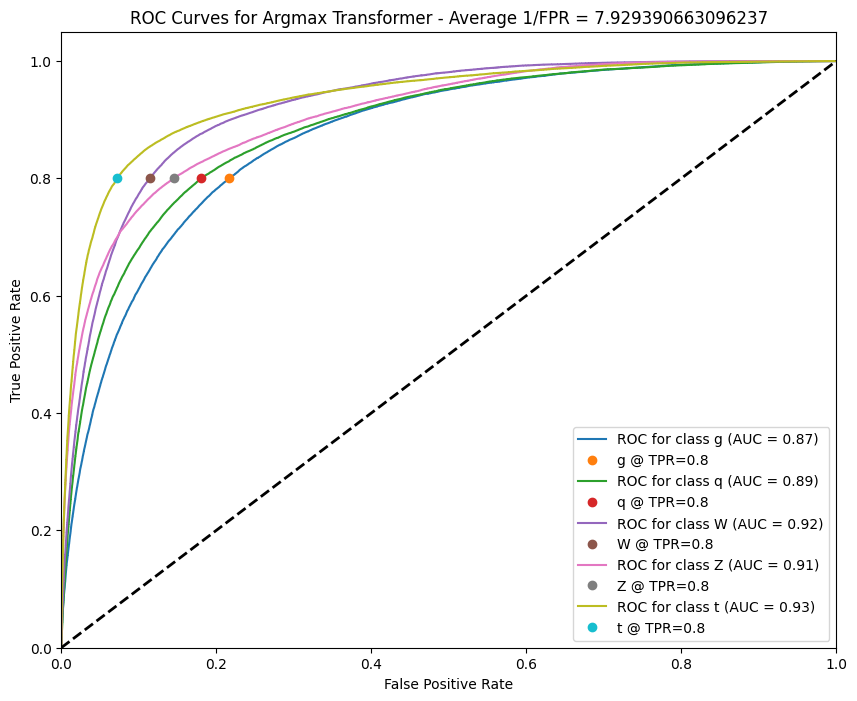

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()

